## Analysis of hotspot in 2018

In [2]:
library(ggplot2)
library(sqldf)
options(encoding="UTF-8")

Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite


In [3]:
hotspot<-read.csv("https://raw.githubusercontent.com/Maplub/AirQualityData/master/count_50km.csv")
colnames(hotspot)<-c("id","acq_date","count")
hotspot$date<-as.POSIXct(strptime(hotspot$acq_date, "%Y-%m-%d"))

In [4]:
head(hotspot)

id,acq_date,count,date
1,2018-02-22,1,2018-02-22
2,2018-02-23,2,2018-02-23
3,2018-02-24,9,2018-02-24
4,2018-02-25,12,2018-02-25
5,2018-02-26,9,2018-02-26
6,2018-02-27,3,2018-02-27


In [5]:
min(hotspot$date)
max(hotspot$date)

[1] "2018-02-22 +07"

[1] "2018-04-30 +07"

In [6]:
daily<-read.csv("https://raw.githubusercontent.com/Maplub/AirQualityData/master/PM2-5_2018_Daily.csv")
colnames(daily)<-c('sensorid','date','pm25')
head(daily)

sensorid,date,pm25
CU-S0001,28-02-2018,52.52500
CU-S0002,15-02-2018,62.89826
CU-S0002,16-02-2018,50.96376
CU-S0002,17-02-2018,77.15833
CU-S0002,18-02-2018,79.91827
CU-S0002,19-02-2018,72.95452


In [7]:
daily$timepos <- as.POSIXct(strptime(daily$date, "%d-%m-%Y"))

In [8]:
newdaily<-daily[daily$timepos>="2018-02-22" & daily$timepos<="2018-04-30",]
newdaily<- newdaily[order(newdaily$timepos, newdaily$sensorid),]

### Deal with missing values

Create full date daily with distinct sensor id from newhour

In [9]:
datefull<-seq(from=min(newdaily$timepos),to=max(newdaily$timepos), by="day")

In [10]:
sensor_newdaily<-sqldf('select distinct(sensorid) from newdaily')

merge data to get every sensor with full datetime


In [11]:
fulldata<-merge(sensor_newdaily,datefull)
colnames(fulldata)[2]<-'timepos'

merge full data with raw data. leave null values จะได้ข้อมูลที่เว้นว่างวันที่ไม่มีข้อมูล

In [12]:
newdaily<-sqldf('select f.sensorid,f.timepos,n.pm25 from fulldata f LEFT JOIN newdaily n ON f.sensorid = n.sensorid AND f.timepos=n.timepos')

In [13]:
count_na<-aggregate(pm25 ~ sensorid, data=newdaily, function(x) {sum(is.na(x))}, na.action = NULL)
sensorFull<-count_na$sensorid[which(count_na$pm25<10)]
sensorFull

[1] CU-S0002 CU-S0003 CU-S0004 CU-S0006 CU-S0008 CU-S0011 CU-S0013 CU-S0014
 [9] CU-S0015 CU-S0017 CU-S0021 CU-S0022 CU-S0023 CU-S0024 CU-S0028 CU-S0029
[17] CU-S0030 CU-S0032 CU-S0033 CU-S0035 CU-S0039 CU-S0042 CU-S0046 CU-S0047
[25] CU-S0050 CU-S0051 CU-S0054 CU-S0060 CU-S0064 CU-S0073 CU-S0076 CU-S0081
[33] CU-S0082 CU-S0086 CU-S0090 CU-S0091 CU-S0093 CU-S0096 CU-S0098 CU-S0101
94 Levels: CU-S0001 CU-S0002 CU-S0003 CU-S0004 CU-S0005 CU-S0006 ... CU-SOO94

In [14]:
newdaily<-subset(newdaily,sensorid %in% sensorFull)

Warning message:
“Removed 10 rows containing missing values (geom_path).”

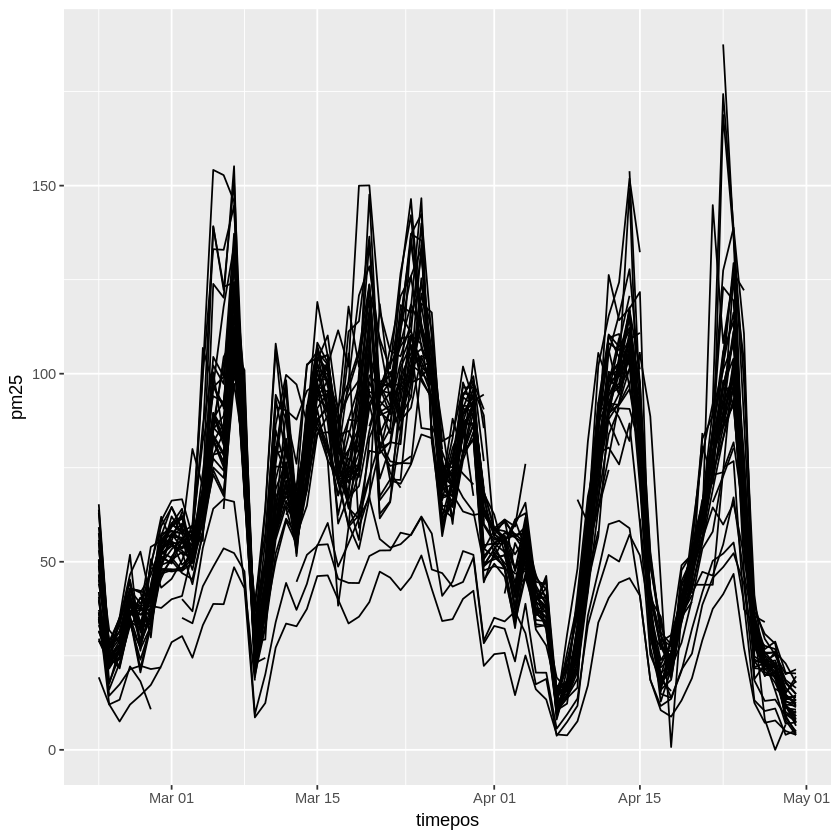

In [15]:
ggplot(data=newdaily, aes(x=timepos, y=pm25, group=sensorid)) + geom_line()

In [16]:
avg_daily_pm25<-sqldf("select timepos,avg(pm25) as avgpm25 from newdaily group by timepos")

In [17]:
datadaily<-sqldf('select a.timepos,a.avgpm25,h.count from avg_daily_pm25 a LEFT JOIN hotspot h ON a.timepos=h.date')

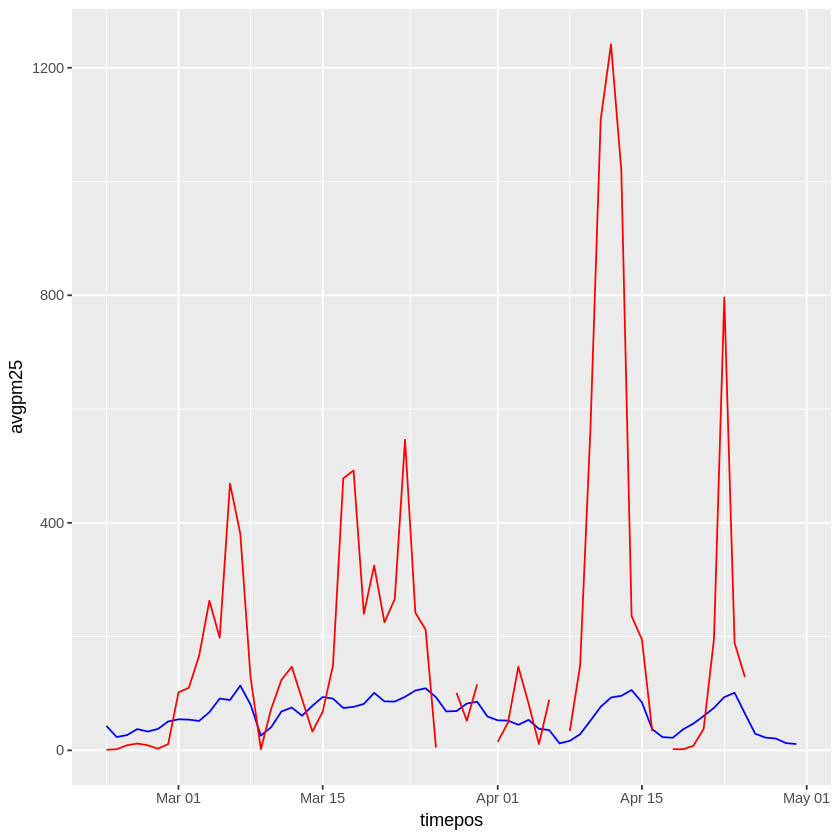

In [18]:
ggplot(data=datadaily,aes(x=timepos)) + geom_line(aes(y=avgpm25), color='blue') + geom_line(aes(y=count), color='red')

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
“Removed 7 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 7 rows containing missing values (geom_point).”

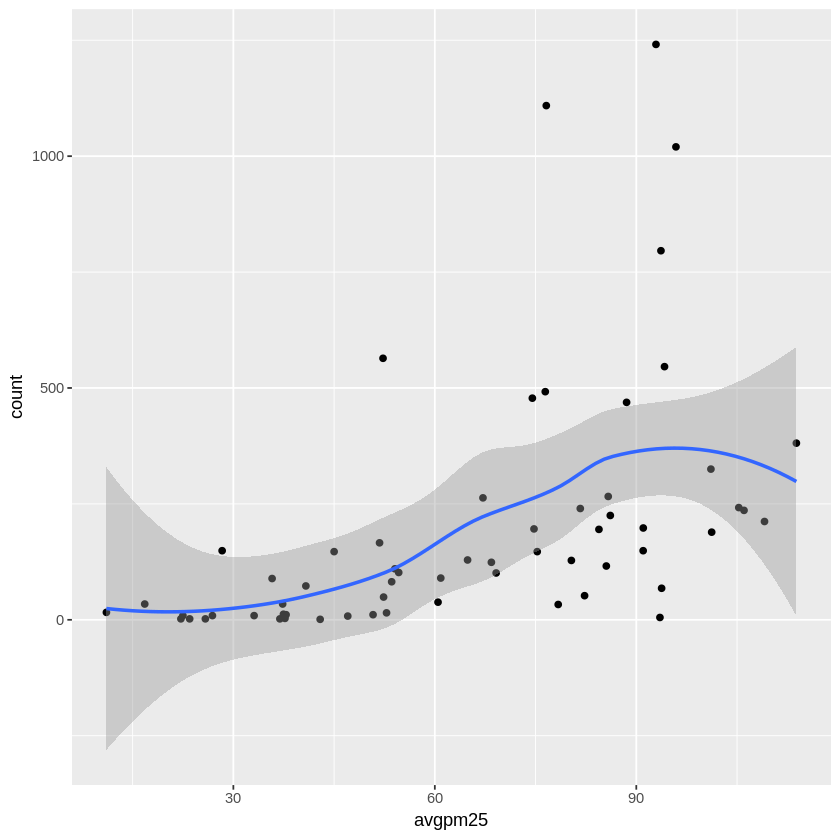

In [19]:
ggplot(data=datadaily,aes(x=avgpm25,y=count)) + geom_point() + geom_smooth()  

Try CCF plot. The result shows lag 1 and cyclical pattern

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



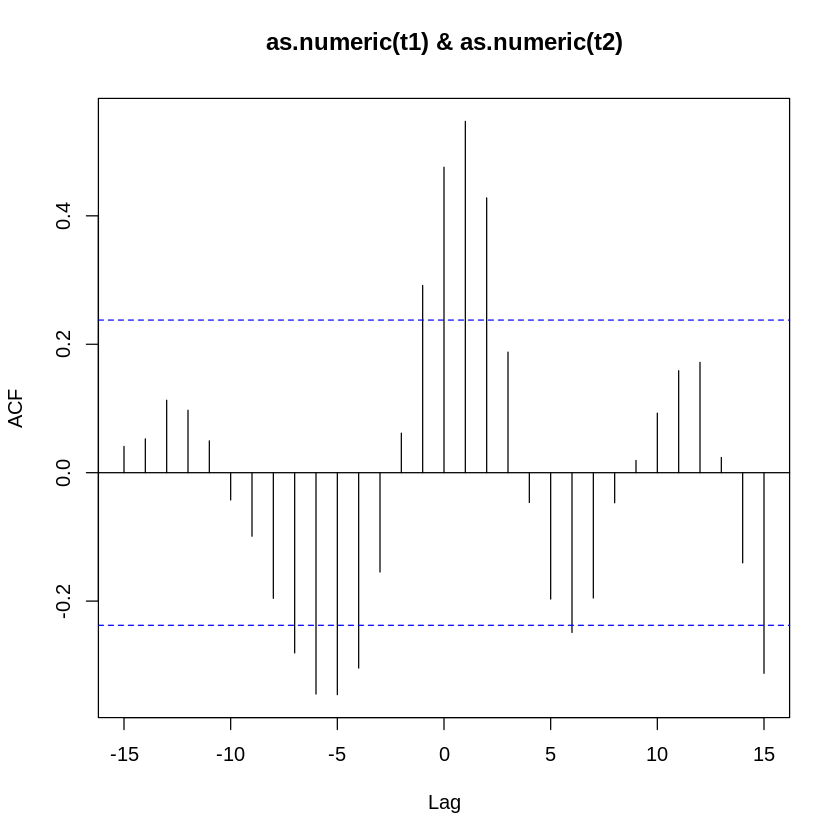

In [20]:
library(xts)
t1<-xts(datadaily$avgpm25,datadaily$timepos)
t2<-xts(datadaily$count,datadaily$timepos)
ccf(as.numeric(t1), as.numeric(t2),na.action = na.pass) 

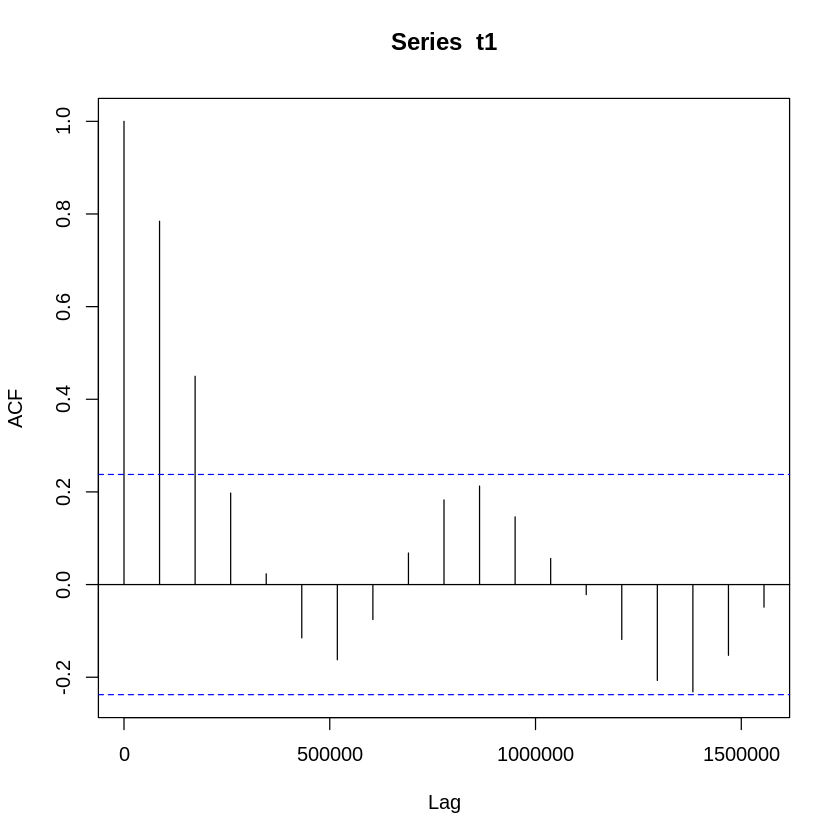

In [48]:
acf(t1,na.action=na.pass)

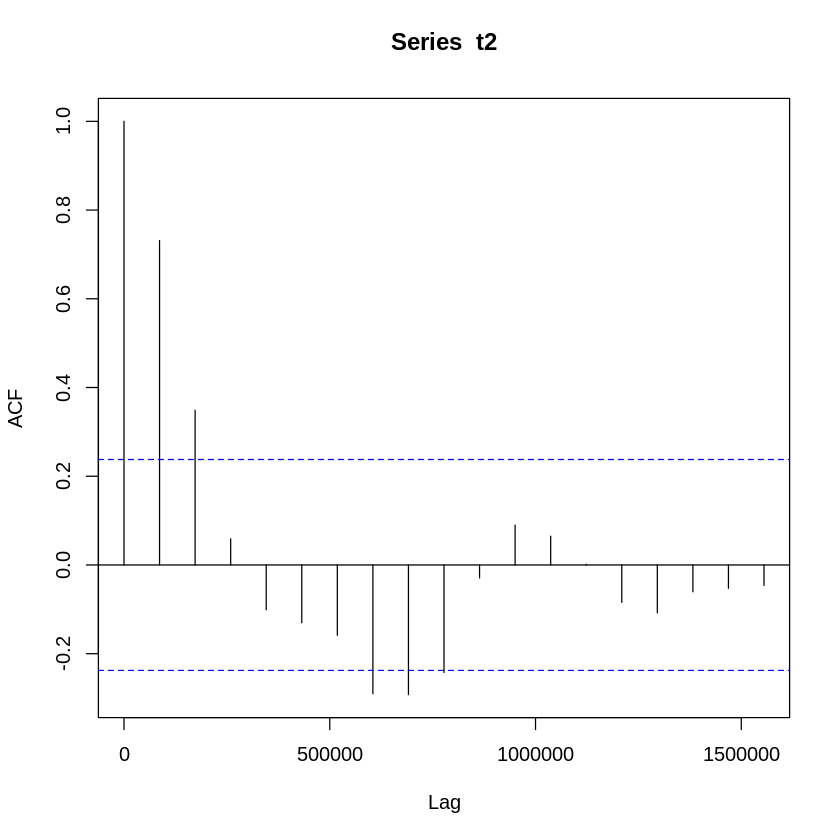

In [47]:
acf(t2,na.action=na.pass)

In [28]:
datadaily$dowf<-weekdays(datadaily$timepos)

In [29]:
library(lubridate)
datadaily$d<-day(datadaily$timepos)
datadaily$m<-month(datadaily$timepos)
datadaily$y<-year(datadaily$timepos)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



In [32]:
datadaily$woy<-as.numeric(format(datadaily$timepos,"%W"))
library(plyr)
datadaily<-ddply(datadaily,.(m),transform,monthweek=1+woy-min(woy))


Attaching package: ‘plyr’

The following object is masked from ‘package:lubridate’:

    here



In [39]:
head(datadaily)

timepos,avgpm25,count,dowf,d,m,y,woy,monthweek
2018-02-22,42.92536,1,Thursday,22,2,2018,8,1
2018-02-23,23.49560,2,Friday,23,2,2018,8,1
2018-02-24,26.88207,9,Saturday,24,2,2018,8,1
2018-02-25,37.45860,12,Sunday,25,2,2018,8,1
2018-02-26,33.09036,9,Monday,26,2,2018,9,2
2018-02-27,37.68598,3,Tuesday,27,2,2018,9,2


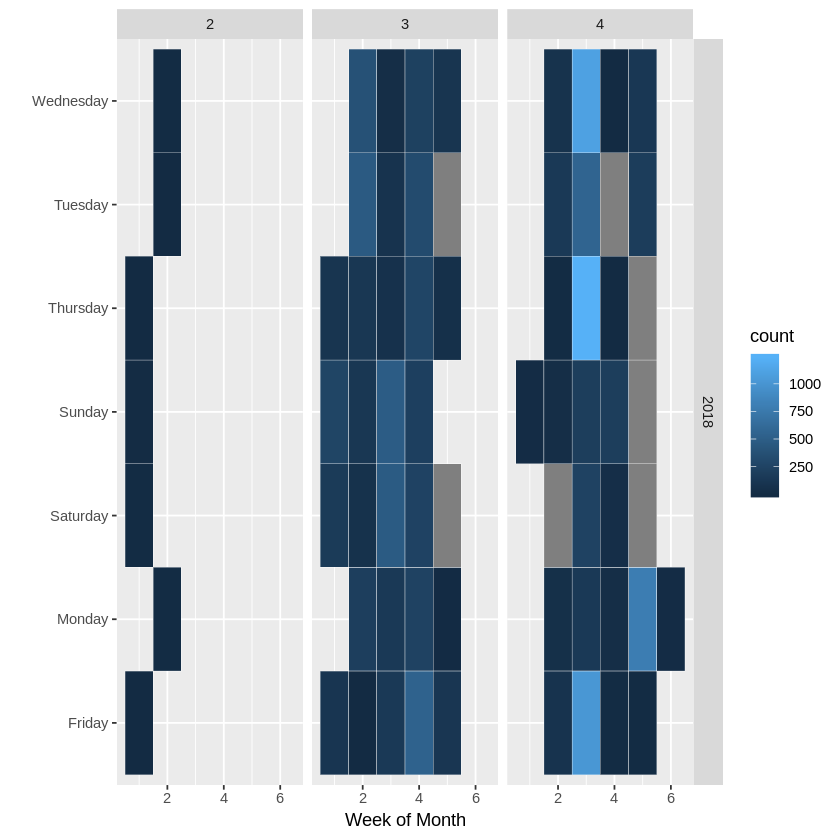

In [38]:
ggplot(datadaily, aes(monthweek,dowf)) + geom_tile(aes(fill = count),colour = "white") + facet_grid(y~m) + xlab("Week of Month") + ylab("")